# Running HBV Model for FR000119

## Importing Python modules

In [1]:
!pip install "rich[jupyter]"
!pip install "geopandas"

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

## Choose region and time period

In [3]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

In [4]:
#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

<Axes: >

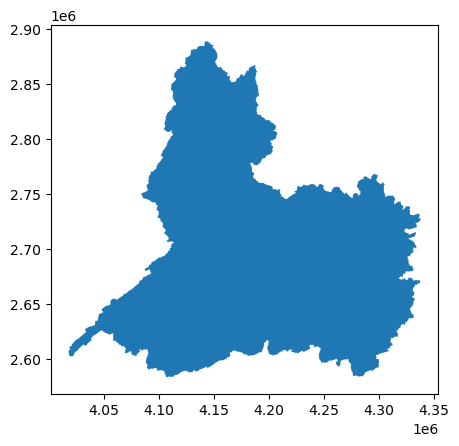

In [5]:
#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [6]:
print(f"Basin area: {basin_area:.2f} km²")

Basin area: 48437.19 km²

In [7]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 forcing

In [8]:
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [9]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

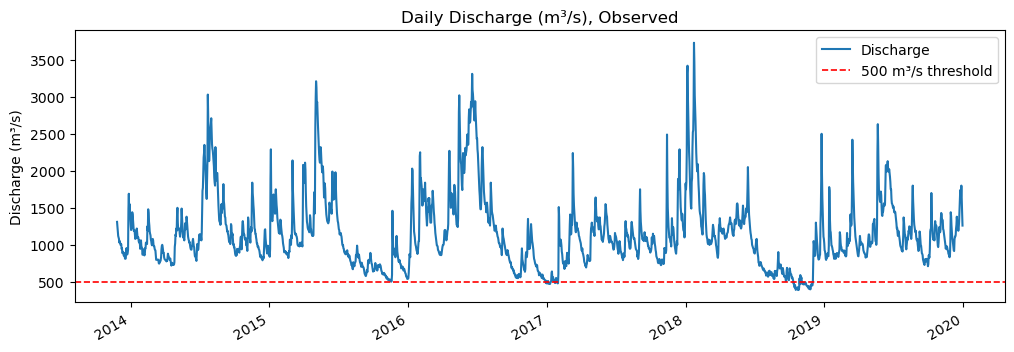

In [22]:
# Plot
ax = Q_obs.plot(figsize=(12, 4), title="Daily Discharge (m³/s), Observed", label="Discharge")
plt.ylabel("Discharge (m³/s)")
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')
plt.legend()
plt.show()

## Load parameters from calibration


In [11]:
# Calibrated parameters RMSE & EMD
par_0 = [5.2023, 0.7735, 514.3276, 2.1726, 0.1879, 6.8253, 0.017, 0.0099, 2.9328]
param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

# Initial storages for HBV (in mm)
# [Si, Su, Sf, Ss, Sp]
s_0 = np.array([0, 100, 0, 5, 0])

In [12]:
# Create HBV model instance with prepared ERA5 forcing
model = HBV(forcing=ERA5_forcing)

config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
model.initialize(config_file)

In [13]:
# Run the model
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

model.finalize()

## Show results

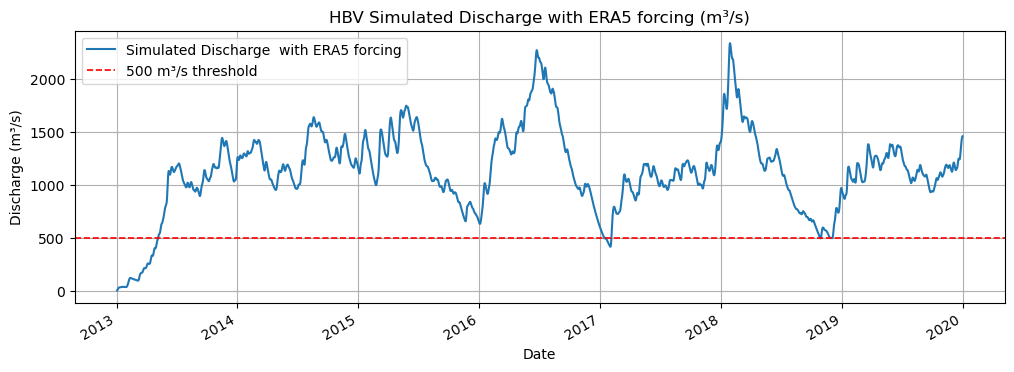

In [24]:
simulated_discharge = pd.Series(data=Q_m, index=time, name="Simulated Discharge")

# Convert HBV output (mm/day) to m³/s
def convert_to_m3s(Q_mmday, area_km2):
    return Q_mmday * area_km2 * 1e3 / 86400

# Convert simulated discharge
Q_sim_m3s = convert_to_m3s(simulated_discharge, basin_area)
Q_sim_m3s.name = "Simulated Discharge  with ERA5 forcing"

# Plot m³/s
Q_sim_m3s.plot(figsize=(12, 4), title="HBV Simulated Discharge with ERA5 forcing (m³/s)")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Date")
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')
plt.legend()
plt.grid()
plt.show()

## Observed VS Simulated

In [15]:
Q_obs_m3s = discharge_series.copy()
Q_obs_m3s.name = "Observed Discharge"

# Convert both indices to timezone
Q_sim_m3s.index = Q_sim_m3s.index.tz_localize(None)
Q_obs_m3s.index = Q_obs_m3s.index.tz_localize(None)

# Align
start = max(Q_sim_m3s.index.min(), Q_obs_m3s.index.min())
end = min(Q_sim_m3s.index.max(), Q_obs_m3s.index.max())

Q_sim_aligned = Q_sim_m3s[start:end]
Q_obs_aligned = Q_obs_m3s[start:end]

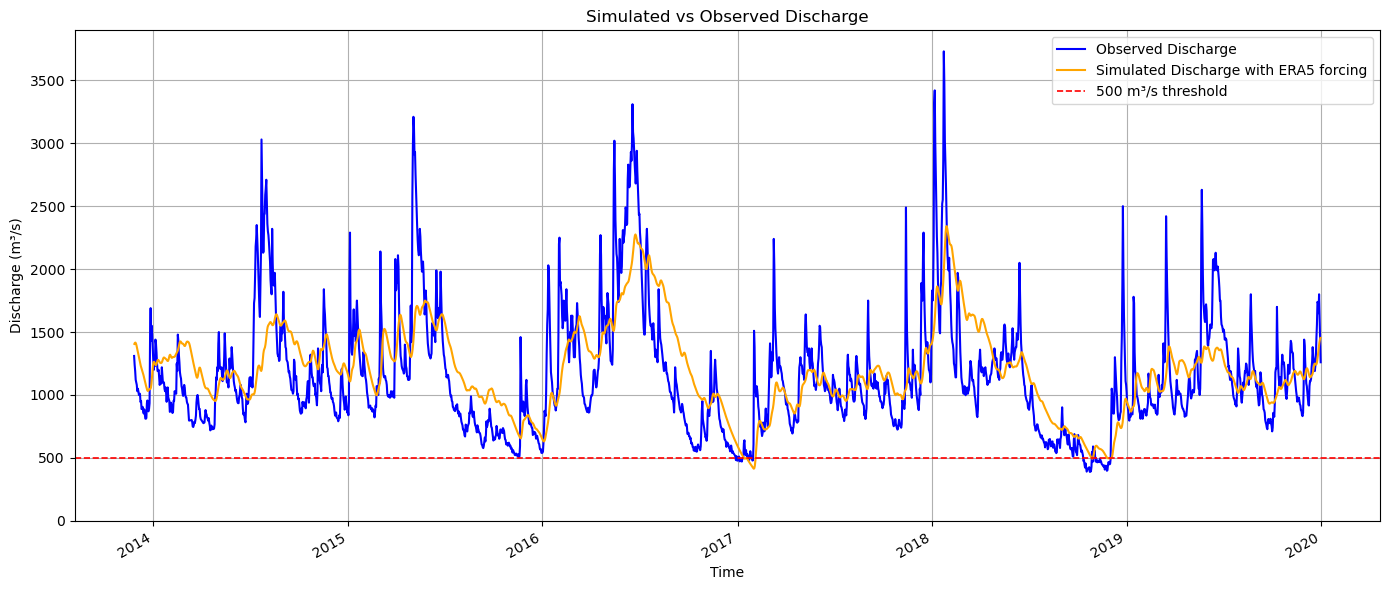

In [16]:
#Plot
plt.figure(figsize=(14, 6))
Q_obs_aligned.plot(label="Observed Discharge", color="blue")
Q_sim_aligned.plot(label="Simulated Discharge with ERA5 forcing", color="orange")
plt.title("Simulated vs Observed Discharge")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Time")

# Get current y-limits to create y ticks
ymin, ymax = plt.ylim()

# Define new ticks including 500
yticks = np.arange(0, ymax + 1, 500)
if 500 not in yticks:
    yticks = np.append(yticks, 500)
    yticks = np.sort(yticks)

# Set the ticks before showing the plot
plt.yticks(yticks)
plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
